In [145]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
# import dask.dataframe as dd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
# import warnings
# warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

# %matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

# pd.set_option('max_columns', 50)
# plt.style.use('bmh')
# color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])



In [102]:
#!/Users/soraward/opt/miniconda3/bin/python3 
data_root = "../../data/"
# ML stuff
import numpy as np
from numpy.fft import *
import torch

from sklearn.linear_model import Lasso
import pandas as pd


from PIL import Image
# plotting
import matplotlib.pyplot as plt
import seaborn as sns


# basic stuff
import datetime
import requests
import io
from collections import Counter

#stats stuff
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [103]:
# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c


# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq

# create features volatility, volume, adj close
def get_features(nasdaq):
    #rename Adj Close
    nasdaq.rename(columns={"Adj Close":"Adj_Close"}, inplace=True)
    nasdaq["log_Volatility"] = np.log(nasdaq.High - nasdaq.Low + 1)
    nasdaq["log_Volume"] = np.log(nasdaq.Volume + 1) 
    nasdaq["log_Adj_Close"] = np.log(nasdaq["Adj_Close"] + 1)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()
    nasdaq.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq.dropna(inplace = True)
    return nasdaq

# this will return feature engineered stock dataframe
def get_stock(nasdaq, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

# for ARIMA or some shit    
def reindex(df):
    return df.reindex(pd.date_range(df.index[0], df.index[-1])).fillna(method="ffill")

In [104]:
nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
# nasdaq.groupby("Name").apply(lambda df: print(df.shape))

# the line below is to get same sized data
    # first_names = list(set([name for name in nasdaq.Name]))
    # using = []
    # for i in first_names:
    #     if nasdaq.groupby("Name").get_group(i).shape == (2943, 8):
    #         using.append(i)
    # len(using)
features = {'Adj_Close', 'log_Volatility', 'log_Volume', 'log_Adj_Close'}
using = ['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']
# AAPL(Apple), MSFT(Microsoft), GOOGL(Google), AMZN(Amazon), TSLA(Tesla), FB(Facebook), NVDA(Nvidia)

In [183]:
####### In the 2 functions below, we are adding weekday however ###########
####### prob we could have done this in like get_stock or something #######
# the main difference between the two is , the prior is just adding weekday at the end,
# whereas the latter function is adding it to every stock
def get_train_df(nasdaq, using, features):
    df_features_arr = reindex(get_stock(nasdaq, using[0])).to_numpy().T
    for name in using[1:]:
        adding = reindex(get_stock(nasdaq, name)).to_numpy().T
        df_features_arr = np.concatenate([df_features_arr, adding])
    df_features_arr = df_features_arr.T

    ## df_features = pd.DataFrame(data=df_features_arr, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))
    
    # making columns
    # features must not include weekday here
    if "weekday" in features:
        features.remove("weekday")
    col_one = []
    for element in using:
        for i in range(len(features)):
            col_one.append(element)
    col_two = list(features)*len(using)
    print(len(col_one), len(col_two))
    # scaling 
    scaler = MinMaxScaler((-1, 1))
    scaled = scaler.fit_transform(df_features_arr)
    df_features = pd.DataFrame(data=scaled, columns=pd.MultiIndex.from_tuples(zip(col_one, col_two)))

    df_features.index = pd.date_range("2012-05-18", "2021-09-10")

    day_of_week = np.array(list(map(lambda date: date.weekday(), df_features.index)))
    day_of_week = day_of_week.reshape(-1, 1)
    day_of_week = pd.Series(data=scaler.fit_transform(day_of_week).reshape(-1,), index = df_features.index)
    df_features["weekday"] = day_of_week
    features.add("weekday")

    return df_features, features

from sklearn.preprocessing import MinMaxScaler

# for feeding into network
def get_train_arr(nasdaq, using, features):
    df_features_arr = []
    for name in using:
        arr = reindex(get_stock(nasdaq, name)).to_numpy()
        # scaling for each column, for each stock_df in nasdaq
        scaler = MinMaxScaler(feature_range=(-1, 1))
        arr_scaled = scaler.fit_transform(arr)    

        # adding day of week
        day_of_week = np.array(list(map(lambda date: date.weekday(), pd.date_range("2012-05-18", "2021-09-10"))))
        day_of_week = day_of_week.reshape(-1, 1)
        day_of_week = scaler.fit_transform(day_of_week)
      
        arr_scaled = np.concatenate([arr_scaled, day_of_week], axis=1)

        df_features_arr.append(arr_scaled)


    df_features_arr = np.array(df_features_arr)
    features.add("weekday")
    df_features_arr = df_features_arr.reshape(-1, len(features), 7)

    return df_features_arr, features

# This isn't working with LSTM, so we will scratch it
# def sliding_windows_mutli_features(data, seq_length):
#     x = []
#     y = []

#     for i in range((data.shape[0])-seq_length-1):
#         #change here after finishing feature engineering process
#         _x = data[i:(i+seq_length),2:, :] 
#         _y = data[i+seq_length, 1, :] ## column 1 contains the labbel(log_Adj_Close)
#         x.append(_x)
#         y.append(_y)

#     return np.array(x), np.array(y)

seq_len 
def sliding_windows_mutli_features(data, seq_length, target_cols_ids):
    x = []
    y = []

    for i in range((data.shape[0])-seq_length-1):
        #change here after finishing feature engineering process
        _x = data[i:(i+seq_length), :] 
        _y = data[i+seq_length, target_cols_ids] ## column 1 contains the labbel(log_Adj_Close)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [203]:
# this part is sketchy
df, features = get_train_df(nasdaq, using, features)

target_cols_ids = []
count = 0
for col in df.columns:
    if col[1] == "Adj_Close":
        df.drop(col, axis=1, inplace=True)
        count -= 1
    if col[1] == "log_Adj_Close":
        target_cols_ids.append(count)
    count += 1
df = df.to_numpy()
x, y = sliding_windows_mutli_features(df, 100, target_cols_ids)

x.shape, y.shape


28 28


((3302, 100, 22), (3302, 7))

In [197]:
# train test split (70:30)
train_size = int(len(y)*0.80)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

# trainX = Variable(torch.Tensor(np.array(x[0:train_size, :, :, :])))
# trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
# testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([2641, 100, 22])
train label shape is: torch.Size([2641, 7])
test shape is: torch.Size([661, 100, 22])
test label shape is: torch.Size([661, 7])


In [204]:
device = torch.device('cpu')

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length

        self.dropout = nn.Dropout(p=0.2)
        
        # what does the batch_first do
        self.lstm = nn.LSTM(\
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True,
            dropout = 0.25)
        
        # Linear(in_features, out_features)
        self.fc = nn.Linear(hidden_size, num_classes)                                                                                                                                                                                                                           

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)                                         
        out = self.dropout(out)
       
        return out

In [206]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [207]:
###### Parameters #######
num_epochs = 500
learning_rate = 1e-3
input_size = 22 # features(?)
hidden_size = 512
num_layers = 1
num_classes = 7 # because we are using 7 stocks
#########################
best_val_loss = 100                        

### Init Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

### Set Criterion Optimizer and scheduler
criterion = torch.nn.MSELoss().to(device) 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, min_lr=1e-7, eps=1e-08)

#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train model
for epoch in progress_bar(range(num_epochs)):
    lstm.train()
    outputs= lstm(trainX.to(device))
    optimizer.zero_grad()

    # obtain loss func
    loss = criterion(outputs, trainY.to(device))
    loss.backward()

    optimizer.step()

    #evaluate on test
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))

    scheduler.step(vall_loss)

    if vall_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
         best_val_loss = vall_loss.cpu().item()

    if epoch%50==0:
        print(f"Epoch: {epoch}, loss: {loss.cpu().item()}, valid loss:{vall_loss.cpu().item()}")

    


/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, loss: 0.2383776605129242, valid loss:0.4665040373802185
Epoch: 50, loss: 0.048364702612161636, valid loss:0.15256907045841217
Epoch: 100, loss: 0.04762072488665581, valid loss:0.10319547355175018
Epoch: 150, loss: 0.04659058898687363, valid loss:0.08056896179914474
Epoch: 200, loss: 0.04639464616775513, valid loss:0.07546570152044296
Epoch: 250, loss: 0.04615047946572304, valid loss:0.0701027661561966
Epoch: 300, loss: 0.0442599356174469, valid loss:0.06700675189495087
Epoch: 350, loss: 0.04653855040669441, valid loss:0.06431397795677185


In [220]:
lstm.state_dict()['lstm.weight_ih_l0'].shape

torch.Size([2048, 22])

In [210]:
torch.save(lstm.state_dict(), 'model1_0.pt')

In [ ]:
###### Parameters #######
num_epochs = 500
learning_rate = 1e-3
input_size = 22 # features(?)
hidden_size = 512
num_layers = 1
num_classes = 7 # because we are using 7 stocks
#########################
best_val_loss = 100                        

### Init Model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

### Set Criterion Optimizer and scheduler
criterion = torch.nn.MSELoss().to(device) 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, min_lr=1e-7, eps=1e-08)

#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train model
for epoch in progress_bar(range(num_epochs)):
    lstm.train()
    outputs= lstm(trainX.to(device))
    optimizer.zero_grad()

    # obtain loss func
    loss = criterion(outputs, trainY.to(device))
    loss.backward()

    optimizer.step()

    #evaluate on test
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))

    scheduler.step(vall_loss)

    if vall_loss.cpu().item() < best_val_loss:
         torch.save(lstm.state_dict(), 'best_model.pt')
         print("saved best model epoch:",epoch,"val loss is:",vall_loss.cpu().item())
         best_val_loss = vall_loss.cpu().item()

    if epoch%50==0:
        print(f"Epoch: {epoch}, loss: {loss.cpu().item()}, valid loss:{vall_loss.cpu().item()}")

    


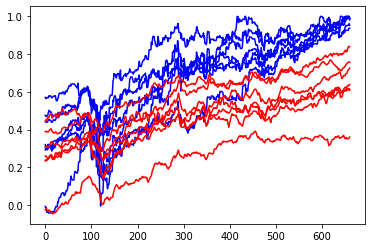

In [231]:
lstm.eval()
pred = lstm(testX.to(device))
pred = pred.to(device).detach().numpy().copy()
plt.plot(testY, c="blue")
plt.plot(pred, c="red")
plt.show()

In [226]:
using

['FB', 'TSLA', 'AAPL', 'AMZN', 'NVDA', 'MSFT', 'GOOGL']

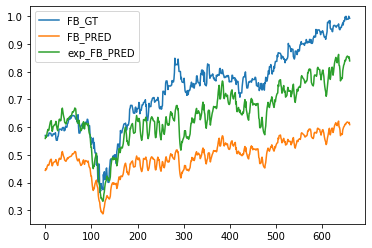

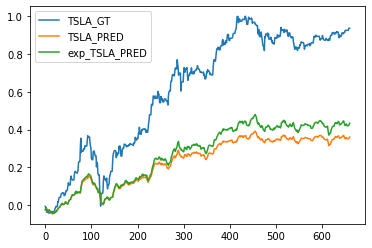

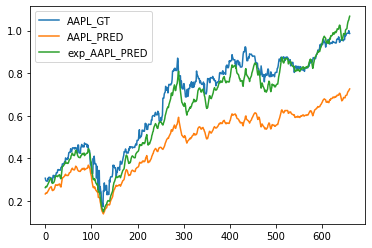

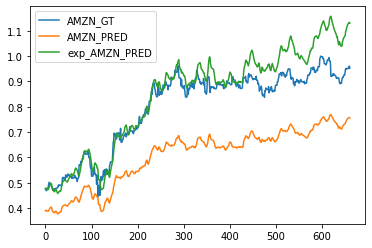

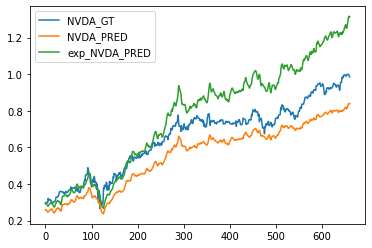

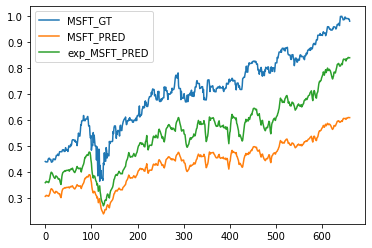

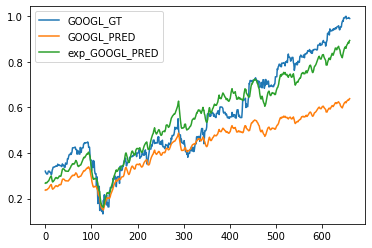

In [236]:
for i in range(7):
    plt.plot(testY[:,i])#, label=using[i]+"_GT")
    plt.plot(pred[:,i])
    plt.plot(np.exp(pred[:,i])-1.)#, label=using[i]+"PRED")
    plt.legend([using[i]+"_GT", using[i]+"_PRED", "exp_"+using[i]+"_PRED"])
    plt.savefig(f"LSTM1_0_{using[i]}_preds.png")
    plt.show()
